<a href="https://colab.research.google.com/github/lucasgneccoh/FNC_nlp_project/blob/main/notebooks/LSTM_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook variables
This variables will define important behaviour when executing the notebook. Define them here

In [8]:
#@title Notebook variables { run: "auto" }

#@markdown These variables will define important behaviour when executing the notebook. Run this cell once, and then changing the parameters will re-run it automatically

#@markdown ---
#@markdown **merge**: Tells whether to merge train and test set of the FNC data, shuffle and re-split into test and train set.
merge = True #@param {type:"boolean"}

# Imports and initial definitions

## Clone repository

In [1]:
import os
%cd /content
!git clone https://github.com/lucasgneccoh/FNC_nlp_project.git

os.chdir("/content/FNC_nlp_project")

/content
Cloning into 'FNC_nlp_project'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 124 (delta 50), reused 29 (delta 5), pack-reused 0
Receiving objects: 100% (124/124), 26.27 MiB | 34.89 MiB/s, done.
Resolving deltas: 100% (50/50), done.


## Install gensim and make imports

In [2]:
!pip install gensim==4.0.0b

     |████████████████████████████████| 24.0MB 132kB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import gensim
import torch
import torchtext
import spacy
from nltk import tokenize
import pandas as pd
import gensim.parsing.preprocessing as prep
import re

from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Example, Iterator, Dataset
import torchtext.vocab as vocab


import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Data
Here we read the data and process it to create the needed datasets and dataloaders

## Read and prepare data

In [5]:
def process_data_frames(stances, bodies):
    """
    Create three pandas DataFrame objects representing the FNC data

    Parameters
    ----------
    stances: pandas.DataFrame
        DataFrame with the following structure: Headline, Body ID, Stance
        Stance takes the values 'unrelated', 'agree', 'disagree', 'discuss'

    bodies: pandas.DataFrame
        DataFrame with the following structure: Body ID, Body

    Returns
    -------
        stances: Body ID, Headline ID, stance label
        bodies: Body ID, Body
        Headlines: Headline ID, Headline
    """
    uni = stances['Headline'].unique()
    uni_keys = dict(zip(uni, range(len(uni))))
    labels_dict = {'unrelated':0, 'agree':1, 'disagree':2, 'discuss':3}
    stances['Headline ID'] = stances['Headline'].map(uni_keys)
    stances['Stance'] = stances['Stance'].map(labels_dict)
    headlines = stances.loc[:,['Headline ID', 'Headline']].drop_duplicates(subset=['Headline ID']).set_index('Headline ID')

    bodies.set_index('Body ID', inplace=True)
    bodies.rename(columns={'articleBody': 'Body'}, inplace=True)
    stances.drop(columns=['Headline'], inplace=True)

    return stances, bodies, headlines

class FNC_Dataset(torch.utils.data.Dataset):
    """ Dataset with the FNC data (headline, body, stance)
        We represent each observation using a dictionary.
        The text can be preprocessed with a custom function

        Parameters
        ----------
        stances_file: str
            Name of the original stances csv file containing Headline, Body ID
            and Stance

        bodies_file: str
            Name of the original bodies csv file containing Body ID and Body

        path: str
            Base path to prepend to the the file names. Absolute path to the 
            csv files will be the one returned by os.path.join(`path`, `file_name`)

        processing: function
            Function to process a sentence. It takes a str and returns a list of
            str representing the tokenized and preprocessed sentenced 
    """
  
    def __init__(self, stances_file, bodies_file, path, processing):
        """ Creates an instance of the FNC_Dataset by loading the original csv
            files and creating internal pandas DataFrame object with the data
        """
        stances = pd.read_csv(os.path.join(path, stances_file))
        bodies = pd.read_csv(os.path.join(path, bodies_file))
        self.stances, self.bodies, self.headlines = process_data_frames(stances, bodies)
        # Function to pass from line of text to input
        self.processing = processing
  
    def __len__(self):
        return len(self.stances)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        row = self.stances.iloc[idx]    
        h, b = self.headlines.loc[row.at['Headline ID']].get('Headline'), self.bodies.loc[row.at['Body ID']].get('Body')
        h, b = self.processing(h), self.processing(b) 
        s = row.at['Stance']
        return {'headline':h, 'body':b, 'stance':s}
        

""" 
We are going to use torchtext in the following cells
torchtext adds the processing on the Field directly and
not in the "source" dataset, so for now we do not preprocess
"""
processing = lambda x: x 

path = 'data/FNC_data'
stances_file = 'train_stances.csv'
bodies_file = 'train_bodies.csv'

data_FNC = FNC_Dataset(stances_file, bodies_file, path, processing)


path = 'data/FNC_data'
stances_file = 'competition_test_stances.csv'
bodies_file = 'competition_test_bodies.csv'

test_FNC = FNC_Dataset(stances_file, bodies_file, path, processing)

In [6]:
# Example of data sample with current configuration
test_FNC[5]

{'body': 'When faced with the choice of feasting on a fine meal of human while listening to Justin Bieber\'s music or fleeing to blessed — but hungry — quiet, one bear in Russia decided that silence is indeed golden.\n\nA report in the Daily Mail details Russian fisherman Igor Vorozhbitsyn\'s unfortunate encounter with the brown bear, who attacked him from behind as he was walking to his favorite fishing spot in the Yakutia Republic. But as the bear was beginning to inflict serious injury on Vorozhbitsyn, his cellphone rang, and the ringtone of Justin Bieber hit "Baby" startled the animal, causing it to beat a hasty retreat.\n\n"I know that sort of ringtone isn\'t to everyone\'s taste but my granddaughter loaded it onto my phone for a joke," Vorozhbitsyn said. Nice work, kid — you just saved Grandpa\'s life with nothing more than a tween anthem.\n\n- - Mike Barry',
 'headline': "Next-generation Apple iPhones' features leaked",
 'stance': 0}

## Select preprocessing

In [7]:
""" Compare tokenizers    
"""
spacy_en = spacy.load('en')
def spacy_tokenizer(text): # create a tokenizer function
    return [tok.text for tok in spacy_en.tokenizer(text)]


# Use the one used before
CUSTOM_FILTERS = [lambda x: x.lower(), lambda x: re.sub('\W+',' ',x) ,\
                           prep.strip_tags, prep.strip_punctuation, \
                           prep.strip_punctuation2, prep.strip_multiple_whitespaces, \
                           prep.strip_numeric, prep.remove_stopwords, prep.strip_short]
processing = lambda x: prep.preprocess_string(x, CUSTOM_FILTERS)



print(data_FNC[0]['headline'])
print('spacey')
print(spacy_tokenizer(data_FNC[0]['headline']))

print('gensim')
print(processing(data_FNC[0]['headline']))

Police find mass graves with at least '15 bodies' near Mexico town where 43 students disappeared after police clash
spacey
['Police', 'find', 'mass', 'graves', 'with', 'at', 'least', "'", '15', 'bodies', "'", 'near', 'Mexico', 'town', 'where', '43', 'students', 'disappeared', 'after', 'police', 'clash']
gensim
['police', 'mass', 'graves', 'bodies', 'near', 'mexico', 'town', 'students', 'disappeared', 'police', 'clash']


## Merge and shuffle train and test data


To choose whether to merge and re-split or not, define the `merge` variable on the [**Variable definition cell**](https://colab.research.google.com/github/lucasgneccoh/FNC_nlp_project/blob/main/notebooks/LSTM_pytorch.ipynb#scrollTo=csVOtXJkQgSV&line=3&uniqifier=1)

In [ ]:
"""
We are considering to merge the train and test set
and then resample the test set, see if we get more 
normal results

merge is defined on the Variable definition cell
"""


if merge:
    all_FNC = torch.utils.data.ConcatDataset([data_FNC, test_FNC])
    new_data_FNC, new_test_FNC = torch.utils.data.random_split(all_FNC, [len(data_FNC), len(test_FNC)], generator=torch.Generator().manual_seed(42))
else:
    new_data_FNC, new_test_FNC = data_FNC, test_FNC

In [ ]:
print(f"data_FNC: {len(data_FNC)}, {len(new_data_FNC)}")
print(f"test_FNC: {len(test_FNC)}, {len(new_test_FNC)}")
N = len(test_FNC)
i = np.random.randint(N)
print(test_FNC[i])
print(new_test_FNC[i])

data_FNC: 49972, 49972
test_FNC: 25413, 25413
{'headline': "Rumors Swirling About Israel's Shocking Sinai 'Endgame' Plan for Palestinians in Gaza", 'body': 'Microsoft will buy Mojang AB.', 'stance': 0}
{'headline': "Rumors Swirling About Israel's Shocking Sinai 'Endgame' Plan for Palestinians in Gaza", 'body': 'Microsoft will buy Mojang AB.', 'stance': 0}


# Create embedding layer

## Create Field and vocabulariy

In [ ]:
%%time
"""
    Here we use tochtext to create the model.
    We have to define the Field objects corresponding to text fields (headline
    and body) and label fields (stance)
    We also have to create a Dataset of Examples 
    See torchtext.legacy.data for more information

    NOTE: This part takes time: I add an if to avoid execution when not needed
"""

if True:
    CUSTOM_FILTERS = [lambda x: x.lower(), lambda x: re.sub('\W+',' ',x) ,\
                        prep.strip_tags, prep.strip_punctuation, \
                        prep.strip_punctuation2, prep.strip_multiple_whitespaces, \
                        prep.strip_numeric, prep.remove_stopwords, prep.strip_short]
    processing = lambda x: prep.preprocess_string(x, CUSTOM_FILTERS)
  # use torchtext to define the dataset field containing text
    TEXT = Field(sequential=True, init_token='<START>', \
                              eos_token='<END>',lower=True, tokenize = processing,\
                              batch_first=True,\
                              is_target=False)
    LABEL = Field(sequential=False, use_vocab=False,\
                               batch_first=True,\
                                is_target=True)

#TRAIN
    fields = {'headline': ('headline', TEXT),\
            'body': ('body', TEXT), 'stance':('stance', LABEL)}
    examples = [Example.fromdict(data=row,fields=fields) \
              for row in new_data_FNC]

    fields = {'headline': TEXT,\
                'body':  TEXT, 'stance':LABEL}
  # load your dataset using torchtext
    train_set = Dataset(examples=examples,fields=fields)

#TEST
    fields = {'headline': ('headline', TEXT),\
                'body': ('body', TEXT), 'stance':('stance', LABEL)}
    examples = [Example.fromdict(data=row,fields=fields) \
                for row in new_test_FNC]

    fields = {'headline': TEXT,\
                'body':  TEXT, 'stance':LABEL}
    # load your dataset using torchtext
    test_set = Dataset(examples=examples,fields=fields)


CPU times: user 1min 18s, sys: 905 ms, total: 1min 19s
Wall time: 1min 19s


## Load vectors into Field
Here we create the embedding layer from pretrained word embeddings

There are two kinds of pre trained word embeddings:
  - The `gensim` pre trained models like Google News or FastText, or even the ones we trained
  - The `torchtext` pretrained models

In [ ]:
%%time

from gensim.models import Word2Vec

# Option 1 = use torchtext pre trained models
# Option 2 = Use a gensim pre trained model
option = 2

# Only if option is 2
# Choose from google_news, fastText
# To use another model, you just need the file of the model or the vectors
# Make sure to load the model/vectors 
gensim_model = "google_news"

if option == 1:
    '''
    Option 1: Use a torchtext pretrained model

    Pre trained models in torchtext
    charngram.100d
    fasttext.en.300d
    fasttext.simple.300d
    glove.6B.200d
    glove.6B.300d
    glove.840B.300d
    See https://torchtext.readthedocs.io/en/latest/vocab.html#pretrained-aliases
    '''
    # Can take several minutes to load
    pre_trained_vector_type = 'glove.6B.300d'  
    TEXT.build_vocab(train_set, test_set, vectors = pre_trained_vector_type)
    


elif option == 2:
    """
    Option 2: Load a gensim Word2Vec model and use it to feed the Field
    Gensim models are sometimes very heavy, so instead of using the gensim 
    download api, it is better to use directly wget when possible
    Make sure the downloaded file can be opened with 
        gensim.models.KeyedVectors.load_word2vec_format
    This means that we do not load models, but only vectors.
    From a gensim model, they can be saved using 
        model.wv.save_word2vec_format('data/embeddings/word2vec_wv')
    """    
    cwd = os.getcwd()
    %cd /content
    !mkdir downloaded_embeddings
    %cd /content/downloaded_embeddings

    if gensim_model == "google_news":
        !wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
        path_model = "/content/downloaded_embeddings/GoogleNews-vectors-negative300.bin.gz"
        binary = True

    elif gensim_model == "fastText":
        !wget -c "https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M-subword.vec.zip"
        !unzip "wiki-news-300d-1M-subword.vec.zip"
        path_model = "/content/wiki-news-300d-1M-subword.vec"
        binary = False

    %cd $cwd   


    model = gensim.models.KeyedVectors.load_word2vec_format(path_model, binary=True)
    TEXT.build_vocab(train_set, test_set)
    W2V_SIZE = model.vector_size
    word2vec_vectors = []    
    for token, idx in TEXT.vocab.stoi.items():
        if token in model.key_to_index:
            word2vec_vectors.append(torch.FloatTensor(model[token]))
        else:
            word2vec_vectors.append(torch.zeros(W2V_SIZE))

    TEXT.vocab.set_vectors(TEXT.vocab.stoi, word2vec_vectors, W2V_SIZE)


# Finally, we use the TEXT Field to build de embedding layer
embedding = torch.nn.Embedding.from_pretrained(torch.FloatTensor(TEXT.vocab.vectors))
    

/content
mkdir: cannot create directory ‘downloaded_embeddings’: File exists
/content/downloaded_embeddings
--2021-04-30 02:31:51--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.72.14
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.72.14|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

/content/FNC_nlp_project


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)


CPU times: user 55.7 s, sys: 3.14 s, total: 58.8 s
Wall time: 59.1 s


## Lets see somme embeddings (and how to get them from the torchtext Field)

In [ ]:
word = "france"
idx = TEXT.vocab.stoi[word]
vec = TEXT.vocab.vectors[idx]
vec

## Check for missing words

In [ ]:
missing_words = []
for i, w in enumerate(TEXT.vocab.itos):
    cond = ((TEXT.vocab.vectors[i] == 0.0).sum().item()==300)
    if i>3 and cond: missing_words.append(w)

N = len(missing_words)
print(f'Total number of words: {len(TEXT.vocab)}')
print(f'Num of missing words: {N}')
ind = np.random.randint(N, size=7)
print(f'Some of them: {[missing_words[i] for i in ind]}')

# The vector associated to this words is the zero vector, the same used for <unk>, <pad>, <sos>, <eos>

Total number of words: 27863
Num of missing words: 5326
Some of them: ['chengdu', 'razul', 'austen', 'brekken', 'meltingcbi', 'barnard', 'tolonews']


# Training the model: Preliminaries
Here we create the necessary iterators to iterate through the data, the LSTM model we are going to use and helper functions to be used during the training

## BucketIterator
The bucket iterator uses the TEXT Field object we created implicitly because it uses the torchtext datasets we created with them

In [ ]:
# Using splits
train_loader, test_loader = BucketIterator.splits((train_set, test_set), batch_sizes=(32,32), device=device,\
                                       sort_key = lambda x: len(x.body),
                                       sort=False,
                                       sort_within_batch=True,
                                       shuffle=True,
                                       repeat=True)


Here are some manipulations of the BucketIterator to show how it works

In [ ]:
# Example of a batch using the .batches functions
# The for loop has to be stoped manually, as the batches will be recalculated 
# when the iterator is exhausted
train_loader.create_batches()
for batch in train_loader.batches:
    # batch is a list of elements of type Example
    print(f'batch is of type {type(batch)}')
    for x in batch:
        # x is an Example
        print('Headline')
        print(x.headline)
        print('Body')
        print(x.body)
        # NOTICE: No padding or numeralization is being done!
        break
    break

batch is of type <class 'list'>
Headline
['woman', 'catches', 'husband', 'cheating', 'twin', 'humiliates']
Body
['nun', 'idea', 'pregnant', 'surprised', 'mother', 'superior', 'sisters', 'gave', 'birth', 'baby', 'boy', 'recently', 'according', 'daily', 'mail', 'south', 'american', 'nun', 'belongs', 'order', 'macerata', 'eastern', 'italian', 'region', 'marche', 'arrived', 'june', 'people', 'suspect', 'pregnant', 'time', 'admitted', 'rushed', 'emergency', 'department', 'bartolomeo', 'eustachio', 'san', 'severino', 'marche', 'fellow', 'sisters', 'complained', 'severe', 'stomach', 'ache', 'doctors', 'immediately', 'deduced', 'nun', 'birth', 'soon', 'delivered', 'healthy', 'baby', 'boy', 'child', 'currently', 'remains', 'hospital', 'undergo', 'checks', 'macerata', 'nuns', 'expressed', 'desire', 'baby', 'raise', 'nun', 'said', 'idea', 'pregnant', 'prior', 'hospital', 'admission', 'time', 'nun', 'mysteriously', 'given', 'birth', 'suffering', 'stomach', 'pains', 'south', 'american', 'nun', 'cas

In [ ]:
train_loader.create_batches()
for batch in train_loader:
    # batch is of type torchtext.data.Batch, which is the good one!
    print(f'batch is of type {type(batch)}')
    print(batch)
    print('Headline')
    print(batch.headline[:3])
    print('Number of <pad> in each headline')
    print((batch.headline == TEXT.vocab.stoi['<pad>']).sum(axis = 1))
    print('Body shape')
    print(batch.body.shape)
    print('Number of <pad> in each body')
    print((batch.body == TEXT.vocab.stoi['<pad>']).sum(axis = 1))
    break

batch is of type <class 'torchtext.legacy.data.batch.Batch'>

[torchtext.legacy.data.batch.Batch of size 32]
	[.headline]:[torch.cuda.LongTensor of size 32x17 (GPU 0)]
	[.body]:[torch.cuda.LongTensor of size 32x119 (GPU 0)]
	[.stance]:[torch.cuda.LongTensor of size 32 (GPU 0)]
Headline
tensor([[   2,   14,    7,   55,   85,  137,    3,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1],
        [   2,  242,  195,   19,  123,   57,  142,   46,   29,    3,    1,    1,
            1,    1,    1,    1,    1],
        [   2,   23, 3163, 3921, 3664,  127,    3,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1]], device='cuda:0')
Number of <pad> in each headline
tensor([10,  7, 10,  9, 13,  0, 13,  8,  7,  6,  9,  6,  7,  8,  9,  6,  8,  6,
         8,  8,  4,  8,  4,  8,  7,  0,  8,  7, 11,  6,  8,  7],
       device='cuda:0')
Body shape
torch.Size([32, 119])
Number of <pad> in each body
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 

In [ ]:
headline = ' '.join([TEXT.vocab.itos[i] for i in batch.headline[0,:]])
print(headline)

<START> islamic state leader baghdadi dead <END> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


## LSTM

In [ ]:
class LSTM_encoder(nn.Module):

    def __init__(self, embedding_layer, embedding_size, dimension=128, agg='last',\
                 headline_output_size=128,body_output_size=128, mlp_size=100, do_dropout=True):
        super(LSTM_encoder, self).__init__()

        self.embedding = embedding_layer
        # we can load a preecomputed embedding and freeze it during training
        # we only need to separately train the Word2Vec or ELMO and import the matrix here
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=embedding_size,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        
        self.drop = nn.Dropout(p=0.4)

        self.fc_headline = nn.Linear(2*dimension, headline_output_size) #because they concat last and first (bidir)
        self.fc_body = nn.Linear(2*dimension, body_output_size) #because they concat last and first (bidir)
        self.agg = agg

        self.mlp_fc_1 = nn.Linear(headline_output_size + body_output_size, mlp_size)
        self.mlp_fc_2 = nn.Linear(mlp_size, 4)
        self.do_dropout = do_dropout

    def forward(self, body, body_len, headline, headline_len):

        body_emb = self.embedding(body)
        headline_emb = self.embedding(headline)
        #allows you to work with different sizes of inputs in the same tensor for batch calculation
        
        ### BODY
        lengths = torch.zeros(body.shape[0]) + body.shape[1]
        # print("body_emb: ", body_emb.shape)
        packed = pack_padded_sequence(body_emb, lengths=lengths, enforce_sorted=False, batch_first=True)

        packed_output, _ = self.lstm(packed)
        # print(packed_output.shape)

        output, _ = pad_packed_sequence(packed_output)        
        #unpack the output (reverse operation of pack_padded_sequence)

        # concat the last and first states of the bidir LSTM

        # Choose output
        # output has shape (seq_len, batch_size, num_directions * hidden_size)
        # print("output: ", output.shape)

        # Last
        if self.agg=='last':
            out_forward = output[-1, :, :self.dimension]
            out_reverse = output[0, :, self.dimension:]   # We were taking the last (-1)
        # Max
        if self.agg=='max':
            pass
        # --------- Concat -------------
        # print("out_forward: ", out_forward.shape)
        out_reduced = torch.cat((out_forward, out_reverse), 1)
  
        # print("out_reduced: ", out_reduced.shape)
        if self.do_dropout:
            x = self.drop(out_reduced)
        else:
            x = out_reduced
        # print("dropout: ", x.shape)
        text_fea = self.fc_body(x)  
        # print("fc: ", x.shape)
        # text_fea = torch.squeeze(x,1)   # Squeeze does not change anything when batch size > 1
        # print("text_fea: ", text_fea.shape)
        body_out = torch.sigmoid(text_fea) # activation


        ### HEADLINE
        lengths = torch.zeros(headline.shape[0]) + headline.shape[1]
        packed = pack_padded_sequence(headline_emb, lengths=lengths, enforce_sorted=False, batch_first=True)
        packed_output, _ = self.lstm(packed)
        output, _ = pad_packed_sequence(packed_output)        
        #unpack the output (reverse operation of pack_padded_sequence)

        # concat the last and first states of the bidir LSTM

        # Choose output
        # output has shape (seq_len, batch_size, num_directions * hidden_size)

        # Last
        if self.agg=='last':
            out_forward = output[-1, :, :self.dimension]
            out_reverse = output[0, :, self.dimension:]
        # Max
        if self.agg=='max':
            pass
        # --------- Concat -------------
        out_reduced = torch.cat((out_forward, out_reverse), 1) 
        if self.do_dropout:
            x = self.drop(out_reduced)
        else:
            x = out_reduced
        text_fea = self.fc_headline(x)
        # text_fea = torch.squeeze(self.fc_headline(self.drop(out_reduced)),1)   
        headline_out = torch.sigmoid(text_fea) # activation      

        out = torch.cat((headline_out, body_out),1) 
        
        ### MLP part
        x = self.mlp_fc_1(out)
        if self.do_dropout:
            x = self.drop(x)
        out = self.mlp_fc_2(x)        
        # Extra dropout?
        # out = self.drop(out)
        return out 

## Checkpoints
Functions used to save and load the state of the training and different results

In [ ]:
# Save and Load Functions
from sklearn.metrics import confusion_matrix
def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

def categorize(output, labels, classes):
    pred = output.argmax(dim=1)
    hits = [((pred==c)*(labels==c)).sum().item() for c in classes]
    return np.array(hits)


def FNC_metric (X,Y) :
    lvl1 = 0.25 * ((X == 3 ) == (Y == 3)).sum()
    lvl2 = 0.75 * ((X < 3) & (X == Y)).sum()
    return lvl1 + lvl2



def metric_on_loader(model, loader, metric):
    model.eval()    
    total_metric = 0
    N = len(loader)
    for i, batch in enumerate(loader): #I don't know where the size are coming from
            
        if i == N: break
        labels = batch.stance
        body = batch.body
        headline = batch.headline
        body_len = torch.Tensor(batch.body.shape[0])
        headline_len = torch.Tensor(batch.headline.shape[0])
        body = body.to(device)
        body_len = body_len.to(device)
        headline = headline.to(device)
        headline_len = headline_len.to(device)
        output = model(body, body_len, headline, headline_len) 
        total_metric += metric(labels.detach().cpu().numpy(),output.argmax(dim=1).detach().cpu().numpy())
    

    return total_metric



# Training Function
destination_folder = 'data/LSTM_training'
def train(model,
          optimizer,
          criterion = nn.CrossEntropyLoss(),
          train_loader = train_loader,
          valid_loader = test_loader, #to be changed once we split
          num_epochs = 5,
          eval_every = len(train_loader),
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []
    classes = [0,1,2,3]
    hits_class_total = []
    hits_class_total_train = []
    conf_batch_train = np.zeros((len(classes),len(classes)))
    conf_batch_test = np.zeros((len(classes),len(classes)))
    conf_list_train = []
    conf_list_test = []
    total_FNC_metric = []

    N_train = len(train_loader)
    N_test = len(valid_loader)
    # training loop
    model.train()
    for epoch in range(num_epochs):
        hits_class_train = np.array([0 for i in classes])
        conf_batch_train = np.zeros((len(classes),len(classes)))
    
        # print('Epoch [{}/{}]'.format(epoch+1, num_epochs)) 
        train_loader.create_batches()
        for i, batch in enumerate(train_loader): #I don't know where the size are coming from
            
            '''
            TRAIN LOOP
            '''
            if i == N_train: break
            labels = batch.stance
            body = batch.body
            headline = batch.headline
            body_len = torch.Tensor(batch.body.shape[0])
            headline_len = torch.Tensor(batch.headline.shape[0])
            body = body.to(device)
            body_len = body_len.to(device)
            headline = headline.to(device)
            headline_len = headline_len.to(device)
            output = model(body, body_len, headline, headline_len) # change inputs            
            
            
            
            loss = criterion(output, labels)
            cats = categorize(output, labels, classes)
            conf_batch_train += confusion_matrix(labels.detach().cpu().numpy(), output.argmax(dim=1).detach().cpu().numpy(), labels=classes)
            hits_class_train += cats
            
            optimizer.zero_grad()
            # print('loss.backward()')
            loss.backward()
            # print('optimizer.step()')
            optimizer.step()
            # print('done')  
            # update running values
            running_loss += loss.item()
            # print(loss.item())
            global_step += 1

            # evaluation step
            '''
            EVALUATION
            '''
            if global_step % eval_every == 0:
                
                hits_class = np.array([0 for i in classes])
                conf_batch_test = np.zeros((len(classes),len(classes)))
                
                # print("eval")
                model.eval()
                FNC_met = 0
                with torch.no_grad():                    
                  # validation loop
                  valid_loader.create_batches()
                  for j, batch_t in enumerate(valid_loader):
                      if j == N_test: break
                      labels = batch_t.stance
                      body = batch_t.body
                      headline = batch_t.headline
                      body_len = torch.Tensor(batch_t.body.shape[0])
                      headline_len = torch.Tensor(batch_t.headline.shape[0])
                      body = body.to(device)
                      body_len = body_len.to(device)
                      headline = headline.to(device)
                      headline_len = headline_len.to(device)
                      output = model(body, body_len, headline, headline_len) # change inputs   
                      # print("criterion(output, labels)")
                      loss = criterion(output, labels)
                      cats = categorize(output, labels, classes)
                      hits_class += cats
                      conf_batch_train += confusion_matrix(labels.detach().cpu().numpy(), output.argmax(dim=1).detach().cpu().numpy(), labels=classes)
                      valid_running_loss += loss.item()
                      FNC_met += FNC_metric(labels.detach().cpu().numpy(),output.argmax(dim=1).detach().cpu().numpy())


                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(test_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                hits_class_total.append(hits_class)
                hits_class_total_train.append(hits_class_train)

                conf_list_test.append(conf_batch_test)
                conf_list_train.append(conf_batch_train)
                total_FNC_metric.append(FNC_met)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                # print(hits_class_total)
                torch.save({'accuracy_class': hits_class_total, 'accuracy_class_train': hits_class_total_train}, file_path + '/accuracy_per_class.pt')
                torch.save({'conf_train': conf_list_train, 'conf_test': conf_list_test}, file_path + '/conf_matrices.pt')
                torch.save({'FNC_metric': total_FNC_metric}, file_path + '/FNC_metric.pt')
                save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                    
      
        

    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

# Training the model: Launch training

In [ ]:
model = LSTM_encoder(embedding, 300, dimension=128, agg='last',\
                     headline_output_size=200,\
                     body_output_size=200, mlp_size=128, do_dropout=False)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
best_valid_loss = float("Inf")
save_checkpoint(destination_folder + '/model_start.pt', model, optimizer, best_valid_loss)

criterion = nn.CrossEntropyLoss()
train(model=model, optimizer=optimizer, criterion = criterion, num_epochs=40, train_loader=train_loader, \
      valid_loader=test_loader)

Model saved to ==> data/LSTM_training/model_start.pt
Epoch [1/40], Step [1562/62480], Train Loss: 0.7267, Valid Loss: 0.8358
Model saved to ==> data/LSTM_training/metrics.pt
Model saved to ==> data/LSTM_training/model.pt
Epoch [2/40], Step [3124/62480], Train Loss: 0.5831, Valid Loss: 0.9521
Model saved to ==> data/LSTM_training/metrics.pt
Epoch [3/40], Step [4686/62480], Train Loss: 0.4973, Valid Loss: 1.0042
Model saved to ==> data/LSTM_training/metrics.pt
Epoch [4/40], Step [6248/62480], Train Loss: 0.4486, Valid Loss: 1.1156
Model saved to ==> data/LSTM_training/metrics.pt
Epoch [5/40], Step [7810/62480], Train Loss: 0.4202, Valid Loss: 1.1656
Model saved to ==> data/LSTM_training/metrics.pt
Epoch [6/40], Step [9372/62480], Train Loss: 0.4075, Valid Loss: 1.1878
Model saved to ==> data/LSTM_training/metrics.pt
Epoch [7/40], Step [10934/62480], Train Loss: 0.3864, Valid Loss: 1.2349
Model saved to ==> data/LSTM_training/metrics.pt
Epoch [8/40], Step [12496/62480], Train Loss: 0.3774

KeyboardInterrupt: ignored

In [ ]:
res = metric_on_loader(model, test_loader, FNC_metric)
print(res)

15040.0


## Results

## FNC Metric

No handles with labels found to put in legend.


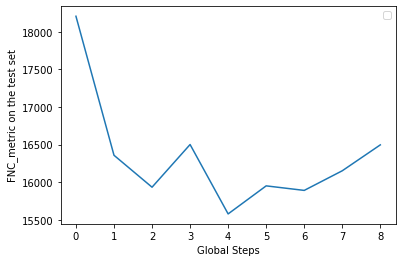

In [ ]:
plot_FNC_metric = torch.load(destination_folder + '/FNC_metric.pt')['FNC_metric']
plt.plot(plot_FNC_metric)
plt.xlabel('Global Steps')
plt.ylabel('FNC_metric on the test set')
plt.legend()
plt.show() 

## Loss

Model loaded from <== data/LSTM_training/metrics.pt


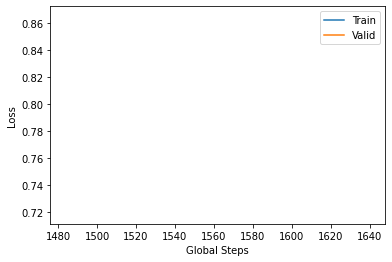

In [ ]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

## Accuracy per class: Train

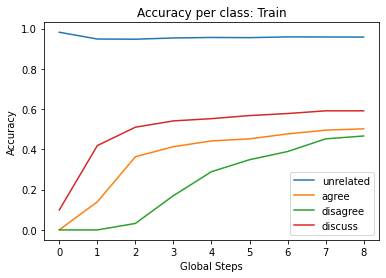

In [ ]:
accu_c = torch.load(destination_folder+'/accuracy_per_class.pt', map_location='cpu')
res = accu_c['accuracy_class_train']
total = [0,0,0,0]
N_max = len(train_loader)
for i, b in enumerate(train_loader):
  if i == N_max: break
  x = b.stance.detach().to('cpu').numpy()
  for c in range(4):
    total[c] += (x==c).sum()

to_plot = np.array(res) / np.array(total)
to_plot = to_plot.T

labels_dict = {'unrelated':0, 'agree':1, 'disagree':2, 'discuss':3}
labels_names = {0:'unrelated', 1:'agree', 2:'disagree', 3:'discuss'}
names = [labels_names[i] for i in range(4)]

for i, n in enumerate(names):
  plt.plot(to_plot[i,:], label=n)

plt.xlabel('Global Steps')
plt.ylabel('Accuracy')
plt.title('Accuracy per class: Train')
plt.legend()
plt.show() 

## Accuracy per class: Validation

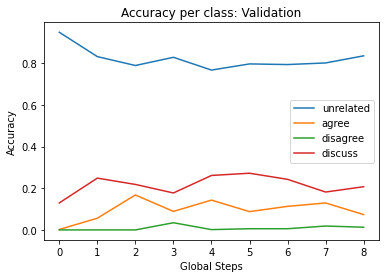

In [ ]:
res = accu_c['accuracy_class']
total = [0,0,0,0]
N_max = len(test_loader)
for i, b in enumerate(test_loader):
  if i == N_max: break
  x = b.stance.detach().to('cpu').numpy()
  for c in range(4):
    total[c] += (x==c).sum()

to_plot = np.array(res) / np.array(total)
to_plot = to_plot.T

for i, n in enumerate(names):
  plt.plot(to_plot[i,:], label=n)

plt.xlabel('Global Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy per class: Validation')
plt.show() 

## Confusion matrices

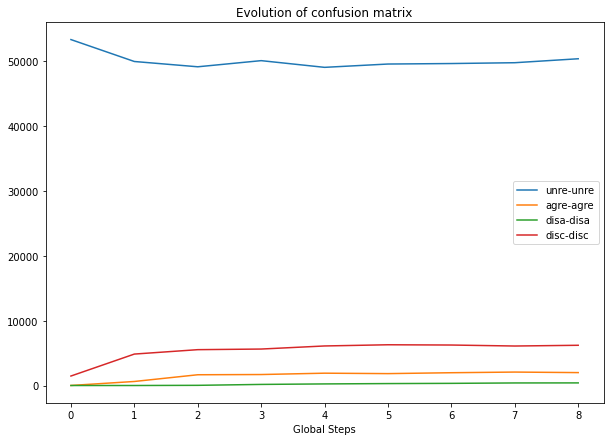

In [ ]:
conf_matrices = torch.load(destination_folder+'/conf_matrices.pt', map_location='cpu')
train_conf = conf_matrices['conf_train']

# Select coordinates of the matrix to plot over the training
# format is (True, Predicted)
show_accuracy = [('unrelated', 'unrelated'), ('agree','agree'), ('disagree','disagree'), ('discuss','discuss')]
divide_by = 'none'


plt.figure(figsize=(10,7))
labels_dict = {'unrelated':0, 'agree':1, 'disagree':2, 'discuss':3}
for t,p in show_accuracy:
  x, y =  labels_dict[t], labels_dict[p]
  
  # Define numerator
  num = lambda M, x, y: M[x,y]

  # Define denominator
  den = lambda M, x, y: 1.0
  if divide_by == 'row':
    den = lambda M, x, y: M[x,:].sum()
  elif divide_by == 'col':
    den = lambda M, x, y: M[:,y].sum()

  z = [num(C, x, y)/den(C,x,y) for C in train_conf]
  plt.plot(z, label = '-'.join([t[:4], p[:4]]))

plt.xlabel('Global Steps')
# plt.ylabel('Accuracy on each class')
plt.legend()
plt.title('Evolution of confusion matrix')
plt.show() 